![Clase aprendizaje no supervisado](https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/taller_4/main/figs/taller-meca-aprendizaje%20no%20supervisado_banner%201169%20x%20200%20px%20-05.png)

# Caso-taller: Identificando  Burger Master con MMG

El Burger Master es un evento creado en el 2016 por el *influencer* Tulio Zuluaga, más conocido en redes como Tulio recomienda, el cual busca que por una semana las hamburgueserías de cada ciudad ofrezcan su mejor producto a un precio reducido.

El evento ha venido creciendo y en el 2022 se extendió por 21 ciudades de Colombia para las cuales se estimó que se vendieron más de dos millones de hamburguesas. El objetivo del presente caso-taller  es identificar los puntos calientes de hamburgueserías  que compitieron en  la ciudad de Bogotá aplicando el Modelo de Mezclas Gaussianas.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo

### 1. Carga de datos  

En la carpeta `data` se encuentra el archivo `burger_master.xlsx` para la ciudad de Bogotá, cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.

In [1]:
# Cargamos los paquetes
import pandas as pd
import numpy as np

In [2]:
# Cargamos los datos de la base burguer_master.xlsx
burguer = pd.read_excel('https://github.com/sebastian23escobar/Aprendizaje_no_supervisado/raw/refs/heads/main/Taller4/data/burger_master.xlsx')
burguer.head()

,Restaurante,Dirección,Descripción,Latitud,Longitud
0,MAIKKI,Cra 75 # 24D – 48,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.668833,-74.116828
1,MAIKKI,Calle 119 # 11A – 24,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.698395,-74.036585
2,MAIKKI,Cra 47A # 98 – 47,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.686401,-74.060144
3,FRENCHEESE,Calle 51 #22-55,"<p>Presentamos «La French Master», inspirada e...",4.639514,-74.073545
4,FRENCHEESE,Calle 80 #14-41,"<p>Presentamos «La French Master», inspirada e...",4.666147,-74.056758


Se cargan los paquetes necesarios y se llama el archivo desde el repositorio de Github, luego se muestra brevemente la información con la instrucción head

### 2.  Visualizando los datos

Visualice la ubicación de cada restaurante en un mapa interactivo. Añada un marcador para cada restaurante y la posibilidad de encontrar la descripción de la hamburguesa ofrecida en un pop-up. (Note que la columna Descripción contiene otra información adicional).

In [3]:
#importamos la librería
import folium

#Mapa base
map = folium.Map(location = [4.6688326,-74.11682789999999], tiles = "OpenStreetMap", zoom_start = 12)
# Otras opciones de tiles
#Stamen Terrain, Toner, and Watercolor

#capa bares
for i in range(0,len(burguer)):
   folium.Marker(
      location=[burguer.iloc[i]['Latitud'], burguer.iloc[i]['Longitud']],
       popup=burguer.iloc[i]['Descripción'],
   ).add_to(map)


#Display el mapa
map

Utilizamos la librería folium en donde se indica que queremos centrar el mapa en las coordenadas 4.6688326,-74.11682789999999, luego, agregamos una capa con las ubicaciones de los restaurantes (indicando la columna de latitud y longitud, finalmente indicamos que los popups deben contener la información de la columna "Descripción".

Análisis: Ya de entrada, con los solos puntos parece haber una alta concentración de restaurantes en Chapinero y el Centro, en el norte también se aprecian varios restaurantes aunque más dispersos en el área.

### 3.  Análisis de puntos calientes

Aplique el modelo de Mezclas Gaussianas para buscar clusters de restaurantes en Bogotá, mencione qué estructura de covarianza usó y explique por qué. Escoja el número óptimo de componentes, explicando el procedimiento y justificando su elección.

In [4]:
# Importamos los paquetes de MMG y relacionados
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt

In [5]:
# Creamos un df llamado "restaurante" en donde guardamos solo las coordenadas.
restaurantes = burguer[['Longitud', 'Latitud']]

In [6]:
#Definimos una función que nos permite crear las curvas de nivel a través de elipses utilizando diferentes objetos de tipo GMM, además incorpora los puntos dentro de los gráficos.
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Dibuja un elipse dado la media y varianza"""
    ax = ax or plt.gca()

    # Convierte las covarianzas
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Dibuja el elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height,
                     angle=angle, **kwargs))
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\App

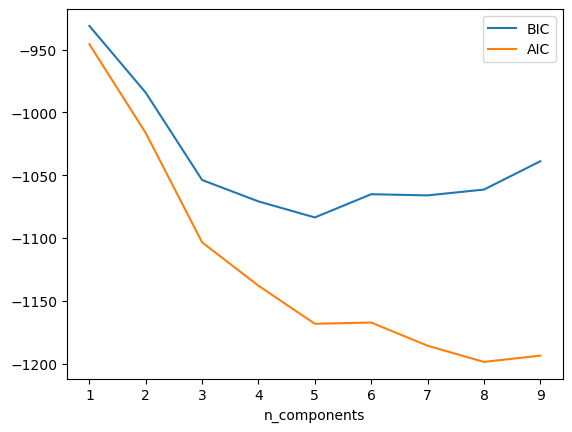

In [7]:
# Hacemos el mismo modelo GMM cambiando la cantidad de componentes y calculamos el BIC para cada uno para saber que cantidad de componentes mínimizan el BIC (BIC penaliza por número de componentes y observaciones)
# Como apreciamos en el siguiente gráfico, usando 5 componentes se mínimiza el BIC (El BIC penaliza por cantidad de componentes y por observaciones).

n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=5678).fit(restaurantes)
          for n in n_components]

plt.plot(n_components, [m.bic(restaurantes) for m in models], label='BIC')
plt.plot(n_components, [m.aic(restaurantes) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [8]:
# Lo mismo se aprecia en la siguiente tabla, usando 5 componentes se mínimiza el BIC (-1083.6)
bica = n_components, [m.bic(restaurantes) for m in models]
bic = ['Componentes', 'BIC']
bic = pd.DataFrame(bica[0], columns=['Componentes'])
bic['BIC'] = pd.DataFrame(bica[1], columns=['BIC'])
bic

,Componentes,BIC
0,1,-931.073643
1,2,-984.252790
2,3,-1053.780856
3,4,-1070.816147
4,5,-1083.569775
5,6,-1065.084293
6,7,-1066.017592
7,8,-1061.392208
8,9,-1038.850326


c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


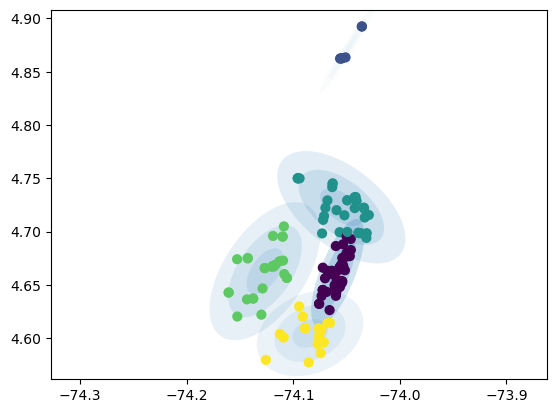

In [9]:
# Cálculamos y gráficamos el modelo MMG con 5 componentes, por ahora usaremos matriz de covarianzas "full"
from sklearn.mixture import GaussianMixture
MMG_restaurantesbic = GaussianMixture(n_components = 5, covariance_type='full', random_state = 0).fit(restaurantes)

# Graficamos
plot_gmm(MMG_restaurantesbic, restaurantes)

#### Que matriz de covarianza debemos usar?

In [10]:
# Para saber cual matriz de covarianza usar, debemos crear un grid en que se evalue por validación cruzada
# el número de componentes y el tipo de matriz de covarianza a usar (tied, spherical, diag o full), 
# esto basado en el BIC mínimo. Usaremos un límite de 5 componentes básados en nuestro análisis anterior.

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 6),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(restaurantes)

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\App

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 6)},
             scoring=<function gmm_bic_score at 0x000002B31B32ED40>)

In [11]:
# Construimos un df con todos las posibles combinaciones de componentes y de matrices, con su respectivo BIC
df_search = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_search["mean_test_score"] = df_search["mean_test_score"]
df_search = df_search.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_search.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
19,5,full,90.580695
18,4,full,109.088358
14,5,diag,111.259012
4,5,spherical,126.456775
3,4,spherical,129.917823


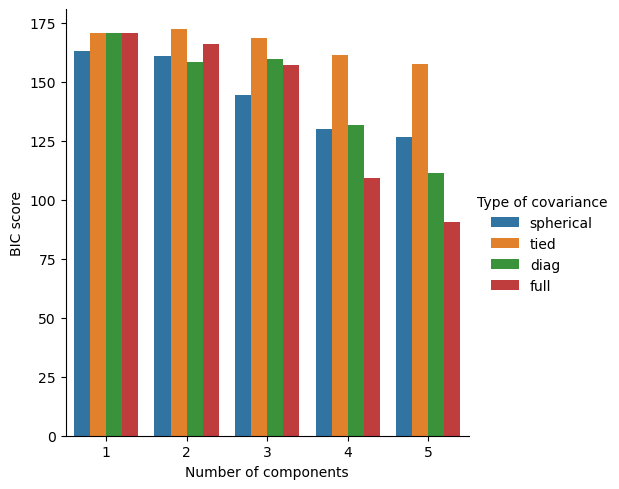

In [12]:
# Graficamos la tabla de resultados anterior, como se puede apreciar, el mejor modelo es full de 5 componentes (cada uno de los 5 componentes tiene su matriz de covarianza completa).
import seaborn as sns
sns.catplot(
    data=df_search,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


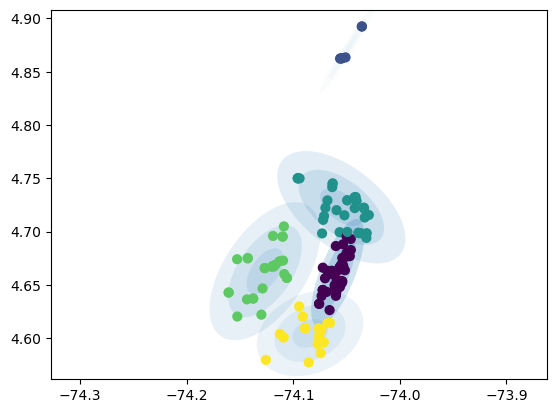

In [13]:
# Nuestro mejor modelo es el siguiente.
MMG_restaurantesBIC = GaussianMixture(n_components = 5, covariance_type='full', random_state = 0).fit(restaurantes)

# Graficamos
plot_gmm(MMG_restaurantesBIC, restaurantes)

Procedimiento: Usando MMG determinamos que la mejor cantidad de componentes a usar es 5 (basados en una matriz de covarianzas "full"), a partir de este resultado creamos realizamos CV para determinar con que cantidad de componentes y tipo de matrices de covariaza se obtiene un mejor BIC (usamos BIC porque penaliza el número de componentes y la cantidad de observaciones del modelo).

Análisis: El mejor modelo según el procedimiento es de 5 componentes con matriz de covarianza completa (full), como podemos apreciar en el gráfico, en efecto, parece haber una correcta identificación de puntos calientes según nuestra estimación preliminar (Chapinero, Centro, Fontibon, Norte/Cedritos y Chia).


#### 3.1. Visualización de los resultados

Visualice las densidades estimadas por el  mejor modelo estimado en la sección anterior usando un mapa de calor interactivo, discuta los resultados.

In [14]:
#Cargamos los paquetes
import numpy as np
import folium
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import io

In [15]:
# Entrenamos el mejor modelo GMM
resnum = restaurantes.to_numpy()
gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=4567)
gmm.fit(resnum)

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GaussianMixture(n_components=5, random_state=4567)

In [16]:
#Creamos malla geográfica
lon_min, lon_max = resnum[:, 0].min(), resnum[:, 0].max()
lat_min, lat_max = resnum[:, 1].min(), resnum[:, 1].max()

lon = np.linspace(lon_min, lon_max, 300)
lat = np.linspace(lat_min, lat_max, 300)

lon_grid, lat_grid = np.meshgrid(lon, lat)
grid_coords = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])

In [17]:
#Evaluamos densidad
log_dens = gmm.score_samples(grid_coords)
dens = np.exp(log_dens).reshape(lat_grid.shape)
dens_norm = (dens - dens.min()) / (dens.max() - dens.min())

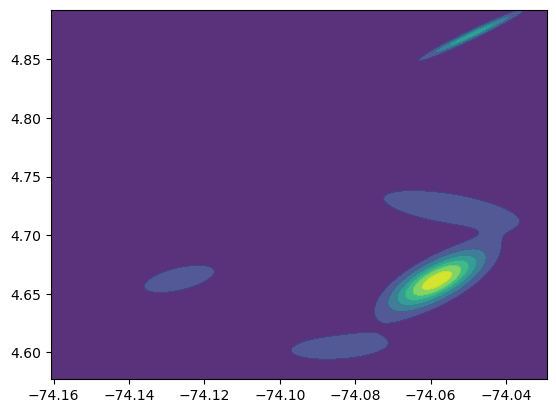

In [18]:
#Creamos mapa de calor estático
import geojsoncontour
contourf_normal_reference = plt.contourf(lon_grid, lat_grid, dens_norm,
    alpha =0.9, linestyles='None')

geojson_normal_reference = geojsoncontour.contourf_to_geojson(
    contourf=contourf_normal_reference,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)

In [19]:
# Creamos mapa de calor interativo con Folium/OpenStreetMaps
m1 = folium.Map(location=[resnum[:, 1].mean(), resnum[:, 0].mean()], zoom_start=12)

folium.GeoJson(
    geojson_normal_reference,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
         'fillColor': x['properties']['fill'],
        'lineColor': '#FFFFFF',
        'opacity':   0.5,
    }).add_to(m1)

# Agregamos Puntos reales
for lat, lon in resnum:
    folium.CircleMarker([lon, lat], radius=1, color='black', fill=True, fill_opacity=0.3).add_to(m1)

m1

Procedimiento: a partir del mejor modelo se creo un grid en donde evaluamos las densidades normalizadas, luego creamos un gráfico con el mapa de calor basado en la densidad, calculado a partir del grid de densidades; finalmente superpusimos el gráfico de calor sobre el mapa de Folium para finalmente agregar los puntos.

Análisis: Gracias al mapa de calor de densidades podemos ver que es en Chapinero donde se concentran la mayor cantidad de restaurantes participantes del Burguer Master, si bien, los gráficos del punto anterior (3.0) mostraban 5 clusteres importantes, gracias al mapa de calor de densidad se puede apreciar mucho mejor que el cluster de Chapinero es el más relevante para el estudio. Esto es fuertemente corroborado por los puntos donde se ubican los restaurantes (puntos negros) en donde a simple vista se ve que es Chapinero la localidad con mayor densidad de restaurantes.

Finalmente, es importante mencionar que en Chia hay un punto denso según el mapa de calor pero se debe más a la proximidad de los restaurantes y a la ausencia de los mismos alrededor; por ejemplo, en Fontibon hay 5 restaurantes en la carrera 75 entre calle 24 y avenida el Dorado, y no aparece en el mapa de calor tanta intensidad como en Chia, lo cual resulta extraño por lo que siempre es útil cotejar el modelo con los datos.

### 4. Comparación con KDE

Estime ahora las densidades usando KDE bivariado de la librería `statsmodels` con el anchos de banda dado por `cv_ml`. Muestre los resultados usando un mapa interactivo. Compare los resultados obtenidos por el "mejor" modelo encontrado via MMG.

In [20]:
#Cargamos las librerías
import geopandas as gpd
import statsmodels.api as sm

In [ ]:
#Creamos un df reorganizando Latitud y Longitud
dta = restaurantes[['Latitud', 'Longitud']]

# Ejecutamos le modelo KDE indicando que tanto en x e y son variables continuas, y adicionalmente los anchos de banda se calcularán por "cross validation maximum likelihood".
dens_robos_normal_reference = sm.nonparametric.KDEMultivariate(data=dta, var_type='cc', bw='cv_ml')


c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


In [ ]:
# Creamos Grilla de valores dentro del rango observado
lon_min, lon_max = resnum[:, 0].min(), resnum[:, 0].max()
lat_min, lat_max = resnum[:, 1].min(), resnum[:, 1].max()

x = np.linspace(lon_min, lon_max, 300)
y = np.linspace(lat_min, lat_max, 300)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack(( yy.flatten(),xx.flatten()))

In [ ]:
# Estimamos las densidades
f_hat_burguer_normal_reference=dens_robos_normal_reference.pdf(data_predict=grid)

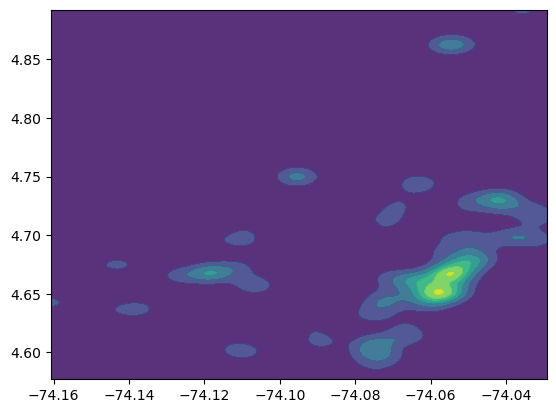

In [33]:
#Creamos el mapa de calor con las densidades calculadas
import geojsoncontour
contourf_normal_reference = plt.contourf(xx, yy, f_hat_burguer_normal_reference.reshape(xx.shape),
    alpha =0.9, linestyles='None')

geojson_normal_reference = geojsoncontour.contourf_to_geojson(
    contourf=contourf_normal_reference,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)

In [35]:
#Superpnemos el mapa de calor dentro del mapa Folium OSM

m2 = folium.Map(location=[resnum[:, 1].mean(), resnum[:, 0].mean()], zoom_start=12)

folium.GeoJson(
    geojson_normal_reference,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
         'fillColor': x['properties']['fill'],
        'lineColor': '#FFFFFF',
        'opacity':   0.5,
    }).add_to(m2)

# Agregamos Puntos reales
for lat, lon in resnum:
    folium.CircleMarker([lon, lat], radius=1, color='black', fill=True, fill_opacity=0.3).add_to(m2)

m2

Procedimiento: Al igual que en GMM, estimamos el modelo KDE bivariado (variables continuas y anchos de banda estimados con CV_ml), luego creamos un grid, y estimaremos las densidades del modelo, creamos un mapa de calor de las densidades, y luego lo incluimos dentro del mapa de Folium.

Análisis: El modelo hila más fino con la detección de puntos de calor y aunque no hay puntos tan densos como Chapinero, se pueden apreciar más concentraciones en diferentes partes de la ciudad, aunque las concentraciones principales siguen siendo las mismas (Fontibon, Centro, Chapinero, Norte/Cedritos y Chia), creemos que para detectar relevacia fue más preciso el modelo GMM, sin embargo, si lo que busca el usuario es encontrar concentraciones débiles, posiblemente el modelo KDE con cv_ml sea más indicado, hacemos la precisión de que es cv_ml porque aunque no aparece en este taller, corrimos el modelo con "normal reference" y dio resultados similares al GMM.

Es de absoluta importacia agregar, que entendemos que si el modelo GMM hubiera usado más componentes, posiblemente hubiera obtenido resultados similares al KDE (cv_ml).

Finalmente queremos mencionar que nos pareció mejor la forma que le dio el modelo KDE a las curvas de densidad en Chia, le restó relevancia al restaurante alejado, es más, el restaurante alejado quedó como un punto diferente (esto por lo que mencionabamos líneas arriba, el modelo KDE hiló en esta ocasión más fino que el GMM pero agrupó menos los clusters).